In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.interpolate as interpolate
import icf
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

#Plot params
plt.rcParams['font.size'] = 16.0
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['lines.linewidth'] = 2.0

In [17]:
5%3

2

Time:  0.00 | FH Amplitude: 0.246
Time:  0.41 | FH Amplitude: 0.222
Time:  0.82 | FH Amplitude: 0.159
Time:  1.22 | FH Amplitude: 0.075
Time:  1.63 | FH Amplitude: 0.035
Time:  2.04 | FH Amplitude: 0.087
Time:  2.45 | FH Amplitude: 0.115
Time:  2.86 | FH Amplitude: 0.106
Time:  3.27 | FH Amplitude: 0.069
Time:  3.67 | FH Amplitude: 0.030
Time:  4.08 | FH Amplitude: 0.042
Time:  4.49 | FH Amplitude: 0.063
Time:  4.90 | FH Amplitude: 0.065
Time:  5.31 | FH Amplitude: 0.049
Time:  5.71 | FH Amplitude: 0.023
Time:  6.12 | FH Amplitude: 0.014
Time:  6.53 | FH Amplitude: 0.025
Time:  6.94 | FH Amplitude: 0.025
Time:  7.35 | FH Amplitude: 0.015
Time:  7.76 | FH Amplitude: 0.003
Time:  8.16 | FH Amplitude: 0.016
Time:  8.57 | FH Amplitude: 0.029
Time:  8.98 | FH Amplitude: 0.039
Time:  9.39 | FH Amplitude: 0.050
Time:  9.80 | FH Amplitude: 0.061
Time: 10.20 | FH Amplitude: 0.066
Time: 10.61 | FH Amplitude: 0.063
Time: 11.02 | FH Amplitude: 0.051
Time: 11.43 | FH Amplitude: 0.036
Time: 11.84 | 

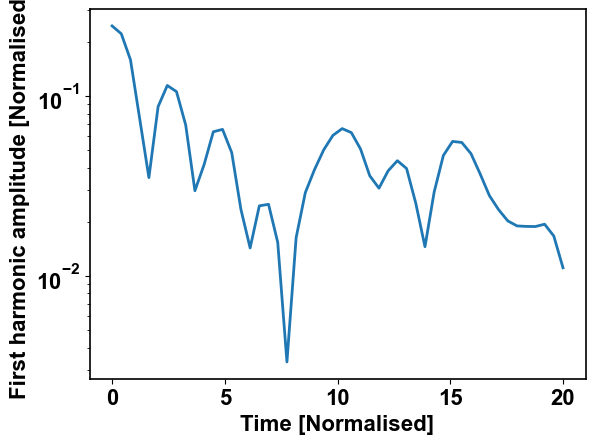

In [31]:
# Electrostatic PIC code in a 1D cyclic domain

from numpy import arange, concatenate, zeros, linspace, floor, array, pi
from numpy import sin, cos, sqrt, random, histogram, abs, sqrt, max

try:
    import matplotlib.gridspec as gridspec  # For plot layout grid - A grid layout to place subplots within a figure.
    got_gridspec = True
except:
    got_gridspec = False

# Need an FFT routine, either from SciPy or NumPy
try:
    from scipy.fftpack import fft, ifft
except:
    # No SciPy FFT routine. Import NumPy routine instead
    from numpy.fft import fft, ifft

def rk4step(f, y0, dt, args=()):
    """ Takes a single step using RK4 method """
    k1 = f(y0, *args)
    k2 = f(y0 + 0.5*dt*k1, *args)
    k3 = f(y0 + 0.5*dt*k2, *args)
    k4 = f(y0 + dt*k3, *args)

    return y0 + (k1 + 2.*k2 + 2.*k3 + k4)*dt / 6.

def calc_density(position, ncells, L):
    """ Calculate charge density given particle positions
    
    Input
      position  - Array of positions, one for each particle
                  assumed to be between 0 and L
      ncells    - Number of cells
      L         - Length of the domain

    Output
      density   - contains 1 if evenly distributed
    """
    # This is a crude method and could be made more efficient
    
    density = zeros([ncells])
    nparticles = len(position)
    
    dx = L / ncells       # Uniform cell spacing
    for p in position / dx:    # Loop over all the particles, converting position into a cell number
        plower = int(p)        # Cell to the left (rounding down)
        offset = p - plower    # Offset from the left
        density[plower] += 1. - offset # corrects value through offset
        density[(plower + 1) % ncells] += offset # put the rest into the nearby cell
    # nparticles now distributed amongst ncells
    density *= float(ncells) / float(nparticles)  # Make max density equal to 1
    return density

def periodic_interp(y, x):
    """
    Linear interpolation of a periodic array y at index x
    
    Input

    y - Array of values to be interpolated
    x - Index where result required. Can be an array of values
    
    Output
    
    y[x] with non-integer x
    """
    ny = len(y)
    if len(x) > 1:
        y = array(y) # Make sure it's a NumPy array for array indexing
    xl = floor(x).astype(int) # Left index
    dx = x - xl
    xl = ((xl % ny) + ny) % ny  # Ensures between 0 and ny-1 inclusive
    return y[xl]*(1. - dx) + y[(xl+1)%ny]*dx

def fft_integrate(y):
    """ Integrate a periodic function using FFTs
    """
    n = len(y) # Get the length of y
    
    f = fft(y) # Take FFT
    # Result is in standard layout with positive frequencies first then negative
    # n even: [ f(0), f(1), ... f(n/2), f(1-n/2) ... f(-1) ]
    # n odd:  [ f(0), f(1), ... f((n-1)/2), f(-(n-1)/2) ... f(-1) ]
    
    if n % 2 == 0: # If an even number of points
        k = concatenate( (arange(0, n/2+1), arange(1-n/2, 0)) )
    else:
        k = concatenate( (arange(0, (n-1)/2+1), arange( -(n-1)/2, 0)) )
    k = 2.*pi*k/n # Transfer into wave numbers (2pi/n)*k
    
    # Modify frequencies by dividing by ik
    f[1:] /= (1j * k[1:]) 
    f[0] = 0. # Set the arbitrary zero-frequency term to zero
    
    return ifft(f).real # Reverse Fourier Transform
   

def pic(f, ncells, L):
    """ f contains the position and velocity of all particles
    """
    nparticles = len(f) // 2     # Two values for each particle
    pos = f[0:nparticles] # Position of each particle
    vel = f[nparticles:]      # Velocity of each particle

    dx = L / float(ncells)    # Cell spacing

    # Ensure that pos is between 0 and L
    pos = ((pos % L) + L) % L
    
    # Calculate number density, normalised so 1 when uniform
    density = calc_density(pos, ncells, L)
    
    # Subtract ion density to get total charge density
    rho = density - 1.
    
    # Calculate electric field
    E = -fft_integrate(rho)*dx
    
    # Interpolate E field at particle locations
    accel = -periodic_interp(E, pos/dx)

    # Put back into a single array
    return concatenate( (vel, accel) )

####################################################################

def run(pos, vel, L, ncells=None, out=[], output_times=linspace(0,20,100), cfl=0.5):
    
    if ncells == None:
        ncells = int(sqrt(len(pos))) # A sensible default

    dx = L / float(ncells)
    
    f = concatenate( (pos, vel) )   # Starting state
    nparticles = len(pos)
    
    time = 0.0
    for tnext in output_times:
        # Advance to tnext
        stepping = True
        while stepping:
            # Maximum distance a particle can move is one cell
            #cfl is a numerical factor to reduce the maximum possible distance
            dt = cfl * dx / max(abs(vel))
            if time + dt >= tnext:
                # Next time will hit or exceed required output time
                stepping = False
                dt = tnext - time
            #f containts positions and velocities
            f = rk4step(pic, f, dt, args=(ncells, L))
            time += dt
            
        # Extract position and velocities
        pos = ((f[0:nparticles] % L) + L) % L
        vel = f[nparticles:]
        
        # Send to output functions
        for func in out:
            func(pos, vel, ncells, L, time)
        
    return pos, vel

####################################################################
# 
# Output functions and classes
#

class Plot:
    """
    Displays three plots: phase space, charge density, and velocity distribution
    """
    def __init__(self, pos, vel, ncells, L):
        
        d = calc_density(pos, ncells, L)
        vhist, bins  = histogram(vel, int(sqrt(len(vel))))
        vbins = 0.5*(bins[1:]+bins[:-1])
        
        # Plot initial positions
        if got_gridspec:
            self.fig = plt.figure()
            self.gs = gridspec.GridSpec(4, 4)
            ax = self.fig.add_subplot(self.gs[0:3,0:3])
            self.phase_plot = ax.plot(pos, vel, '.')[0]
            ax.set_title("Phase space")
            
            ax = self.fig.add_subplot(self.gs[3,0:3])
            self.density_plot = ax.plot(linspace(0, L, ncells), d)[0]
            
            ax = self.fig.add_subplot(self.gs[0:3,3])
            self.vel_plot = ax.plot(vhist, vbins)[0]
        else:
            self.fig = plt.figure()
            self.phase_plot = plt.plot(pos, vel, '.')[0]
            
            self.fig = plt.figure()
            self.density_plot = plt.plot(linspace(0, L, ncells), d)[0]
            
            self.fig = plt.figure()
            self.vel_plot = plt.plot(vhist, vbins)[0]
        plt.ion()
        plt.show()
        
    def __call__(self, pos, vel, ncells, L, t):
        d = calc_density(pos, ncells, L)
        vhist, bins  = histogram(vel, int(sqrt(len(vel))))
        vbins = 0.5*(bins[1:]+bins[:-1])
        
        self.phase_plot.set_data(pos, vel) # Update the plot
        self.density_plot.set_data(linspace(0, L, ncells), d)
        self.vel_plot.set_data(vhist, vbins)
        plt.draw()
        plt.pause(0.05)
        

class Summary:
    def __init__(self):
        self.t = []
        self.firstharmonic = []
        
    def __call__(self, pos, vel, ncells, L, t):
        # Calculate the charge density
        d = calc_density(pos, ncells, L)
        
        # Amplitude of the first harmonic
        fh = 2.*abs(fft(d)[1]) / float(ncells)
        
        # Time is normalised to plasma freq
        print("Time: {:5.2f} | FH Amplitude: {:5.3f}".format(t, fh))
        
        self.t.append(t)
        self.firstharmonic.append(fh)

####################################################################
# 
# Functions to create the initial conditions
#

def landau(npart, L, alpha=0.2):
    """
    Creates the initial conditions for Landau damping
    
    """
    # Start with a uniform distribution of positions
    pos = random.uniform(0., L, npart)
    pos0 = pos.copy()
    k = 2.*pi / L
    for i in range(10): # Adjust distribution using Newton iterations
        pos -= ( pos + alpha*sin(k*pos)/k - pos0 ) / ( 1. + alpha*cos(k*pos) )
        
    # Normal velocity distribution
    vel = random.normal(0.0, 1.0, npart)
    
    return pos, vel

def twostream(npart, L, vbeam=2):
    # Start with a uniform distribution of positions
    pos = random.uniform(0., L, npart)
    # Normal velocity distribution
    vel = random.normal(0.0, 1.0, npart)
    
    np2 = int(npart / 2)
    vel[:np2] += vbeam  # Half the particles moving one way
    vel[np2:] -= vbeam  # and half the other
    
    return pos,vel

####################################################################

if __name__ == "__main__":
    # Generate initial condition
    # 
    npart = 1000   
    if False:
        # 2-stream instability
        L = 100
        ncells = 20
        pos, vel = twostream(npart, L, 3.) # Might require more npart than Landau!
    else:
        # Landau damping
        L = 4.*pi
        ncells = 20
        pos, vel = landau(npart, L)
    
    # Create some output classes
    #p = Plot(pos, vel, ncells, L) # This displays an animated figure - Slow!
    s = Summary()                 # Calculates, stores and prints summary info

    diagnostics_to_run = [ s]   # Remove p to get much faster code!
    
    # Run the simulation
    pos, vel = run(pos, vel, L, ncells, 
                   out = diagnostics_to_run,        # These are called each output step
                   output_times=linspace(0.,20,50)) # The times to output
    
    # Summary stores an array of the first-harmonic amplitude
    # Make a semilog plot to see exponential damping
    plt.figure()
    plt.plot(s.t, s.firstharmonic)
    plt.xlabel("Time [Normalised]")
    plt.ylabel("First harmonic amplitude [Normalised]")
    plt.yscale('log')
    
    plt.ioff() # This so that the windows stay open
    plt.show()
    
    
